- http://forums.fast.ai/t/autoencoder-for-dimensionality-reduction-of-large-sparse-non-image-data/19110/2
- https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py
- https://www.merl.com/publications/docs/TR2016-134.pdf
- http://thesai.org/Downloads/Volume8No11/Paper_3-Multi_Valued_Autoencoders_and_Classification.pdf
- https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
# Importing tensorflow
import tensorflow as tf
# Importing some more libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#loading the images
all_images = np.loadtxt('./data/autoencoder/fashion-mnist_train.csv', delimiter=',', skiprows=1)[:,1:]

#looking at the shape of the file
print(all_images.shape)

(60000, 784)


and the actual image looks like


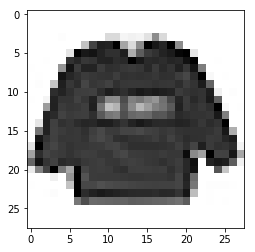

In [3]:
# printing the array representation of the first image
#print("the array of the first image looks like", all_images[0])

# printing something that actually looks like an image
print("and the actual image looks like")
plt.imshow(all_images[0].reshape(28,28),  cmap='Greys')
plt.show()

### NETWORK'S ARQUITECTURE

In [4]:
# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}


In [25]:
#Building the encoder
def encoder(x, phase, keep_probability):
    # Encoder Hidden layer with sigmoid activation #1
    enc1_ful = tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1'])
    enc1_elu = tf.nn.elu(enc1_ful)
    enc1_bn = tf.layers.batch_normalization(enc1_elu, training=phase)
    enc1_dropout = tf.nn.dropout(enc1_bn, keep_prob=keep_probability)
    
    encf_ful = tf.add(tf.matmul(enc1_dropout, weights['encoder_h2']), biases['encoder_b2'])
    encf_elu = tf.nn.elu(encf_ful)
    encf_bn = tf.layers.batch_normalization(encf_elu, training=phase)
    encf_dropout = tf.nn.dropout(encf_bn, keep_prob=keep_probability)
    
    encf_final = tf.nn.tanh(encf_dropout)

    return encf_final

In [26]:
# Building the decoder
def decoder(x, phase, keep_probability):
    # Decoder Hidden layer with sigmoid activation #1
    dec1_ful = tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1'])
    dec1_elu = tf.nn.elu(dec1_ful)
    dec1_bn = tf.layers.batch_normalization(dec1_elu, training=phase)
    dec1_dropout = tf.nn.dropout(dec1_bn, keep_prob=keep_probability)
    
    decf_ful = tf.add(tf.matmul(dec1_dropout, weights['decoder_h2']), biases['decoder_b2'])
    decf_elu = tf.nn.elu(decf_ful)
    decf_bn = tf.layers.batch_normalization(decf_elu, training=phase)
    decf_dropout = tf.nn.dropout(decf_bn, keep_prob=keep_probability)
    
    decf_final = tf.nn.sigmoid(decf_dropout)    
    return decf_final

### Hyperparameters

In [11]:
# Training Parameters
learning_rate = 0.01

In [29]:
keep_prob = tf.placeholder(tf.float32)
training_bn = tf.placeholder(tf.bool)

In [30]:
# image with shape 784 goes in
X = tf.placeholder('float', [None, 784])

# Construct model
encoder_op = encoder(X, phase=training_bn, keep_probability=keep_prob)
decoder_op = decoder(encoder_op, phase=training_bn, keep_probability=keep_prob)


#Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# define our cost function
meansq = tf.reduce_mean(tf.square(y_true - y_pred))

# optimizer methods 
#optimizer = tf.train.AdamOptimizer(learn_rate).minimize(meansq)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(meansq)

In [31]:
# initialising stuff and starting the session

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# defining bath size, number of epochs and learning rate
batch_size = 100 
total_epochs = 2000
tot_images = 60000

# running the model for a 1000 epochs taking 100 images in batches
# total improvement is printed out after each epoch
for epoch in range(total_epochs):
    epoch_loss = 0
    for i in range(int(tot_images/batch_size)):
        epoch_x = all_images[i*batch_size : (i+1)*batch_size]    
        _, c = sess.run([optimizer, meansq], feed_dict={X:epoch_x, 
                                                        y_true:epoch_x,
                                                        keep_prob:0.5,
                                                       training_bn:True})
        epoch_loss += c
    
    print('Epoch', epoch, '/', total_epochs, 'loss:', epoch_loss)    
    

Epoch 0 / 2000 loss: 8005150.2822265625
Epoch 1 / 2000 loss: 7999601.6083984375
Epoch 2 / 2000 loss: 7995996.5712890625
Epoch 3 / 2000 loss: 7993667.9072265625
Epoch 4 / 2000 loss: 7992129.65625
Epoch 5 / 2000 loss: 7991039.97265625
Epoch 6 / 2000 loss: 7990243.6904296875
Epoch 7 / 2000 loss: 7989636.439453125
Epoch 8 / 2000 loss: 7989161.783203125
Epoch 9 / 2000 loss: 7988759.46875
Epoch 10 / 2000 loss: 7988454.8134765625
Epoch 11 / 2000 loss: 7988174.94140625
Epoch 12 / 2000 loss: 7987941.3359375
Epoch 13 / 2000 loss: 7987735.6484375
Epoch 14 / 2000 loss: 7987559.291015625
Epoch 15 / 2000 loss: 7987403.5888671875
Epoch 16 / 2000 loss: 7987265.10546875
Epoch 17 / 2000 loss: 7987129.5595703125
Epoch 18 / 2000 loss: 7987025.7900390625
Epoch 19 / 2000 loss: 7986922.1435546875
Epoch 20 / 2000 loss: 7986825.8056640625
Epoch 21 / 2000 loss: 7986738.2236328125
Epoch 22 / 2000 loss: 7986659.390625
Epoch 23 / 2000 loss: 7986589.97265625
Epoch 24 / 2000 loss: 7986517.564453125
Epoch 25 / 2000 l

Epoch 204 / 2000 loss: 7984981.9638671875
Epoch 205 / 2000 loss: 7984979.7666015625
Epoch 206 / 2000 loss: 7984966.1474609375
Epoch 207 / 2000 loss: 7984980.3603515625
Epoch 208 / 2000 loss: 7984979.1689453125
Epoch 209 / 2000 loss: 7984975.4609375
Epoch 210 / 2000 loss: 7984979.982421875
Epoch 211 / 2000 loss: 7984969.8828125
Epoch 212 / 2000 loss: 7984974.763671875
Epoch 213 / 2000 loss: 7984969.392578125
Epoch 214 / 2000 loss: 7984972.0927734375
Epoch 215 / 2000 loss: 7984967.099609375
Epoch 216 / 2000 loss: 7984967.9404296875
Epoch 217 / 2000 loss: 7984960.3056640625
Epoch 218 / 2000 loss: 7984964.6982421875
Epoch 219 / 2000 loss: 7984962.1064453125
Epoch 220 / 2000 loss: 7984955.720703125
Epoch 221 / 2000 loss: 7984962.357421875
Epoch 222 / 2000 loss: 7984958.4462890625
Epoch 223 / 2000 loss: 7984962.7626953125
Epoch 224 / 2000 loss: 7984958.9658203125
Epoch 225 / 2000 loss: 7984960.5419921875
Epoch 226 / 2000 loss: 7984961.732421875
Epoch 227 / 2000 loss: 7984957.5380859375
Epoch

Epoch 403 / 2000 loss: 7984863.736328125
Epoch 404 / 2000 loss: 7984874.591796875
Epoch 405 / 2000 loss: 7984863.330078125
Epoch 406 / 2000 loss: 7984857.9560546875
Epoch 407 / 2000 loss: 7984862.0888671875
Epoch 408 / 2000 loss: 7984860.2890625
Epoch 409 / 2000 loss: 7984866.0927734375
Epoch 410 / 2000 loss: 7984858.96484375
Epoch 411 / 2000 loss: 7984857.451171875
Epoch 412 / 2000 loss: 7984861.7119140625
Epoch 413 / 2000 loss: 7984862.2392578125
Epoch 414 / 2000 loss: 7984860.890625
Epoch 415 / 2000 loss: 7984864.193359375
Epoch 416 / 2000 loss: 7984865.52734375
Epoch 417 / 2000 loss: 7984853.3173828125
Epoch 418 / 2000 loss: 7984864.9736328125
Epoch 419 / 2000 loss: 7984866.4951171875
Epoch 420 / 2000 loss: 7984862.9619140625
Epoch 421 / 2000 loss: 7984865.3427734375
Epoch 422 / 2000 loss: 7984850.7958984375
Epoch 423 / 2000 loss: 7984854.2470703125
Epoch 424 / 2000 loss: 7984862.1474609375
Epoch 425 / 2000 loss: 7984857.86328125
Epoch 426 / 2000 loss: 7984851.57421875
Epoch 427 / 

Epoch 603 / 2000 loss: 7984825.0
Epoch 604 / 2000 loss: 7984823.9130859375
Epoch 605 / 2000 loss: 7984829.3173828125
Epoch 606 / 2000 loss: 7984822.9501953125
Epoch 607 / 2000 loss: 7984822.8427734375
Epoch 608 / 2000 loss: 7984824.666015625
Epoch 609 / 2000 loss: 7984820.779296875
Epoch 610 / 2000 loss: 7984827.818359375
Epoch 611 / 2000 loss: 7984835.6318359375
Epoch 612 / 2000 loss: 7984825.9501953125
Epoch 613 / 2000 loss: 7984829.775390625
Epoch 614 / 2000 loss: 7984823.890625
Epoch 615 / 2000 loss: 7984820.0126953125
Epoch 616 / 2000 loss: 7984826.564453125
Epoch 617 / 2000 loss: 7984815.2841796875
Epoch 618 / 2000 loss: 7984830.6708984375
Epoch 619 / 2000 loss: 7984821.3837890625
Epoch 620 / 2000 loss: 7984818.1591796875
Epoch 621 / 2000 loss: 7984824.498046875
Epoch 622 / 2000 loss: 7984828.2783203125
Epoch 623 / 2000 loss: 7984823.2197265625
Epoch 624 / 2000 loss: 7984832.2998046875
Epoch 625 / 2000 loss: 7984817.6259765625
Epoch 626 / 2000 loss: 7984815.390625
Epoch 627 / 200

Epoch 803 / 2000 loss: 7984803.4775390625
Epoch 804 / 2000 loss: 7984806.5517578125
Epoch 805 / 2000 loss: 7984797.125
Epoch 806 / 2000 loss: 7984800.8466796875
Epoch 807 / 2000 loss: 7984805.013671875
Epoch 808 / 2000 loss: 7984801.216796875
Epoch 809 / 2000 loss: 7984803.12890625
Epoch 810 / 2000 loss: 7984805.4990234375
Epoch 811 / 2000 loss: 7984800.0380859375
Epoch 812 / 2000 loss: 7984800.7861328125
Epoch 813 / 2000 loss: 7984805.5888671875
Epoch 814 / 2000 loss: 7984798.9990234375
Epoch 815 / 2000 loss: 7984802.197265625
Epoch 816 / 2000 loss: 7984805.7490234375
Epoch 817 / 2000 loss: 7984806.33984375
Epoch 818 / 2000 loss: 7984806.2568359375
Epoch 819 / 2000 loss: 7984805.1708984375
Epoch 820 / 2000 loss: 7984808.212890625
Epoch 821 / 2000 loss: 7984808.7587890625
Epoch 822 / 2000 loss: 7984795.1787109375
Epoch 823 / 2000 loss: 7984808.396484375
Epoch 824 / 2000 loss: 7984793.2138671875
Epoch 825 / 2000 loss: 7984801.8642578125
Epoch 826 / 2000 loss: 7984810.7294921875
Epoch 82

Epoch 1002 / 2000 loss: 7984796.0869140625
Epoch 1003 / 2000 loss: 7984789.91015625
Epoch 1004 / 2000 loss: 7984791.0654296875
Epoch 1005 / 2000 loss: 7984791.701171875
Epoch 1006 / 2000 loss: 7984796.6064453125
Epoch 1007 / 2000 loss: 7984790.2578125
Epoch 1008 / 2000 loss: 7984796.5966796875
Epoch 1009 / 2000 loss: 7984787.66015625
Epoch 1010 / 2000 loss: 7984791.3369140625
Epoch 1011 / 2000 loss: 7984802.8427734375
Epoch 1012 / 2000 loss: 7984789.916015625
Epoch 1013 / 2000 loss: 7984788.765625
Epoch 1014 / 2000 loss: 7984798.4521484375
Epoch 1015 / 2000 loss: 7984782.7646484375
Epoch 1016 / 2000 loss: 7984795.203125
Epoch 1017 / 2000 loss: 7984799.189453125
Epoch 1018 / 2000 loss: 7984804.794921875
Epoch 1019 / 2000 loss: 7984790.064453125
Epoch 1020 / 2000 loss: 7984794.626953125
Epoch 1021 / 2000 loss: 7984790.767578125
Epoch 1022 / 2000 loss: 7984786.328125
Epoch 1023 / 2000 loss: 7984791.578125
Epoch 1024 / 2000 loss: 7984793.947265625
Epoch 1025 / 2000 loss: 7984793.7587890625

Epoch 1197 / 2000 loss: 7984786.0546875
Epoch 1198 / 2000 loss: 7984782.54296875
Epoch 1199 / 2000 loss: 7984787.166015625
Epoch 1200 / 2000 loss: 7984789.470703125
Epoch 1201 / 2000 loss: 7984783.9755859375
Epoch 1202 / 2000 loss: 7984780.8896484375
Epoch 1203 / 2000 loss: 7984777.7958984375
Epoch 1204 / 2000 loss: 7984777.5537109375
Epoch 1205 / 2000 loss: 7984778.8203125
Epoch 1206 / 2000 loss: 7984782.01953125
Epoch 1207 / 2000 loss: 7984792.5126953125
Epoch 1208 / 2000 loss: 7984781.0556640625
Epoch 1209 / 2000 loss: 7984784.7705078125
Epoch 1210 / 2000 loss: 7984790.9970703125
Epoch 1211 / 2000 loss: 7984782.7265625
Epoch 1212 / 2000 loss: 7984788.0927734375
Epoch 1213 / 2000 loss: 7984773.013671875
Epoch 1214 / 2000 loss: 7984794.8515625
Epoch 1215 / 2000 loss: 7984786.6181640625
Epoch 1216 / 2000 loss: 7984781.525390625
Epoch 1217 / 2000 loss: 7984780.1171875
Epoch 1218 / 2000 loss: 7984782.2421875
Epoch 1219 / 2000 loss: 7984783.2275390625
Epoch 1220 / 2000 loss: 7984778.66308

Epoch 1393 / 2000 loss: 7984778.80859375
Epoch 1394 / 2000 loss: 7984772.20703125
Epoch 1395 / 2000 loss: 7984774.4833984375
Epoch 1396 / 2000 loss: 7984775.2685546875
Epoch 1397 / 2000 loss: 7984778.548828125
Epoch 1398 / 2000 loss: 7984777.708984375
Epoch 1399 / 2000 loss: 7984781.322265625
Epoch 1400 / 2000 loss: 7984779.173828125
Epoch 1401 / 2000 loss: 7984786.0244140625
Epoch 1402 / 2000 loss: 7984773.974609375
Epoch 1403 / 2000 loss: 7984785.5986328125
Epoch 1404 / 2000 loss: 7984776.021484375
Epoch 1405 / 2000 loss: 7984777.25
Epoch 1406 / 2000 loss: 7984782.8271484375
Epoch 1407 / 2000 loss: 7984787.1962890625
Epoch 1408 / 2000 loss: 7984780.8701171875
Epoch 1409 / 2000 loss: 7984777.6376953125
Epoch 1410 / 2000 loss: 7984783.70703125
Epoch 1411 / 2000 loss: 7984771.3916015625
Epoch 1412 / 2000 loss: 7984773.564453125
Epoch 1413 / 2000 loss: 7984783.517578125
Epoch 1414 / 2000 loss: 7984772.2724609375
Epoch 1415 / 2000 loss: 7984785.1796875
Epoch 1416 / 2000 loss: 7984784.3935

Epoch 1588 / 2000 loss: 7984774.9228515625
Epoch 1589 / 2000 loss: 7984775.0146484375
Epoch 1590 / 2000 loss: 7984773.7724609375
Epoch 1591 / 2000 loss: 7984773.4130859375
Epoch 1592 / 2000 loss: 7984771.1572265625
Epoch 1593 / 2000 loss: 7984763.8779296875
Epoch 1594 / 2000 loss: 7984776.15234375
Epoch 1595 / 2000 loss: 7984786.6669921875
Epoch 1596 / 2000 loss: 7984772.1845703125
Epoch 1597 / 2000 loss: 7984771.099609375
Epoch 1598 / 2000 loss: 7984779.4755859375
Epoch 1599 / 2000 loss: 7984772.8173828125
Epoch 1600 / 2000 loss: 7984774.6103515625
Epoch 1601 / 2000 loss: 7984781.76171875
Epoch 1602 / 2000 loss: 7984778.4814453125
Epoch 1603 / 2000 loss: 7984773.2783203125
Epoch 1604 / 2000 loss: 7984774.2490234375
Epoch 1605 / 2000 loss: 7984774.88671875
Epoch 1606 / 2000 loss: 7984771.759765625
Epoch 1607 / 2000 loss: 7984779.021484375
Epoch 1608 / 2000 loss: 7984784.4482421875
Epoch 1609 / 2000 loss: 7984779.90234375
Epoch 1610 / 2000 loss: 7984773.283203125
Epoch 1611 / 2000 loss:

Epoch 1783 / 2000 loss: 7984771.880859375
Epoch 1784 / 2000 loss: 7984766.814453125
Epoch 1785 / 2000 loss: 7984772.0068359375
Epoch 1786 / 2000 loss: 7984770.4033203125
Epoch 1787 / 2000 loss: 7984770.861328125
Epoch 1788 / 2000 loss: 7984780.6259765625
Epoch 1789 / 2000 loss: 7984766.5087890625
Epoch 1790 / 2000 loss: 7984770.759765625
Epoch 1791 / 2000 loss: 7984764.0810546875
Epoch 1792 / 2000 loss: 7984775.1279296875
Epoch 1793 / 2000 loss: 7984767.994140625
Epoch 1794 / 2000 loss: 7984770.6474609375
Epoch 1795 / 2000 loss: 7984771.419921875
Epoch 1796 / 2000 loss: 7984770.7861328125
Epoch 1797 / 2000 loss: 7984776.5751953125
Epoch 1798 / 2000 loss: 7984777.3525390625
Epoch 1799 / 2000 loss: 7984778.2412109375
Epoch 1800 / 2000 loss: 7984774.2841796875
Epoch 1801 / 2000 loss: 7984768.0654296875
Epoch 1802 / 2000 loss: 7984773.072265625
Epoch 1803 / 2000 loss: 7984771.53515625
Epoch 1804 / 2000 loss: 7984775.0869140625
Epoch 1805 / 2000 loss: 7984770.4287109375
Epoch 1806 / 2000 lo

Epoch 1978 / 2000 loss: 7984769.400390625
Epoch 1979 / 2000 loss: 7984764.5166015625
Epoch 1980 / 2000 loss: 7984760.6259765625
Epoch 1981 / 2000 loss: 7984763.998046875
Epoch 1982 / 2000 loss: 7984765.466796875
Epoch 1983 / 2000 loss: 7984760.8408203125
Epoch 1984 / 2000 loss: 7984764.1416015625
Epoch 1985 / 2000 loss: 7984770.4482421875
Epoch 1986 / 2000 loss: 7984766.568359375
Epoch 1987 / 2000 loss: 7984767.45703125
Epoch 1988 / 2000 loss: 7984768.2431640625
Epoch 1989 / 2000 loss: 7984771.0478515625
Epoch 1990 / 2000 loss: 7984776.6416015625
Epoch 1991 / 2000 loss: 7984766.64453125
Epoch 1992 / 2000 loss: 7984774.7099609375
Epoch 1993 / 2000 loss: 7984768.6572265625
Epoch 1994 / 2000 loss: 7984770.162109375
Epoch 1995 / 2000 loss: 7984766.01171875
Epoch 1996 / 2000 loss: 7984767.8427734375
Epoch 1997 / 2000 loss: 7984758.9697265625
Epoch 1998 / 2000 loss: 7984759.6904296875
Epoch 1999 / 2000 loss: 7984776.388671875


In [32]:
# pick any image
test_image = all_images[999]
# run it though the autoencoder
output_test_image = sess.run(y_true, feed_dict={X:[test_image], 
                                                keep_prob:1.0, 
                                                training_bn:False})
# run it though just the encoder
encoded_any_image = sess.run(encoder_op, feed_dict={X:[test_image],
                                                    keep_prob:1.0, 
                                                    training_bn:False})

# print the encoding
print(encoded_any_image)

[[ 1.          1.          1.          1.         -0.54119164  1.
   1.          1.         -0.5725925   1.         -0.12058396  1.
  -0.58756053  1.         -0.21978538  1.          1.          1.
  -0.52362466 -0.8632878  -0.4498601   1.          1.          1.
  -0.3160725  -0.22413704 -0.6776145  -0.63684535  1.          1.
   1.         -0.6497666   1.          1.         -0.5360923  -0.16422616
   1.         -0.6230811   1.          1.         -0.5714228   1.
  -0.35146624  1.         -0.4683389   1.         -0.4640801  -0.29780546
  -0.58093786  1.          1.         -0.51696134 -0.25595832  1.
   1.         -0.42199656  1.         -0.212761   -0.37449646  1.
  -0.19974202 -0.6615361  -0.7548297  -0.08628625 -0.8605851   1.
   1.         -0.77574426 -0.18932402 -0.7091162   1.          1.
   1.          1.          1.          1.         -0.6696819   1.
  -0.3377593   1.         -0.6829952   1.         -0.3644013   1.
   1.         -0.44749826 -0.737435   -0.4991134  -0.8655943

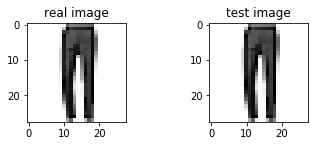

In [33]:
plt.subplot(2,2,1)
plt.imshow(test_image.reshape(28,28), cmap='Greys')
plt.title('real image')

plt.subplot(2,2,2)
plt.imshow(output_test_image.reshape(28,28), cmap='Greys')
plt.title('test image')

plt.show()